Όνομα: Βασίλειος Ραφαήλ Αβραμίδης

Αριθμός Μητρώου: ics23033

Μάθημα: Ανάλυση Δεδομένων μεγάλου Όγκου (Big Data)

Εργασία: Flight Delay Analytics με Apache Spark


In [2]:
#Installing PySpark and JDK packages.
!pip -q install pyspark
!pip -q install matplotlib
!apt-get install openjdk-11-jdk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk openjdk-11-jdk-headless openjdk-

In [3]:
#Getting the flights_2000.csv file from GitHub.
csv_filename = "flights_2000.csv"
csv_url = f"https://raw.githubusercontent.com/billavramidis/spark-flight-delay-analysis/refs/heads/main/data/{csv_filename}"


!wget -q -O {csv_filename} {csv_url}

In [4]:
#Importing Spark and Colab.
from pyspark.sql import SparkSession
from google.colab import files

#Libraries for rounding the average delays.
from pyspark.sql.functions import format_number, col
from pyspark.sql.types import DoubleType

#Libraries necessary for saving the result as .csv file.
import glob
import shutil
import os

#Library for plotting the result.
from matplotlib import pyplot as plt

from time import perf_counter

In [5]:
#Starting Spark session.
spark = SparkSession.builder.appName("Flights").getOrCreate()

In [6]:
#Reading the file.
flights_df = spark.read.csv(csv_filename, header=True, inferSchema=True)

#Printing the Flights DataFrame schema to ensure everything loaded correctly.
flights_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



In [7]:
#Starting counter to calculate Total Runtime.
total_runtime_start = perf_counter()

delayed_flights = (
    flights_df
    .na.drop(subset=["DEP_DELAY", "ARR_DELAY"]) #Filtering out NULL or empty values from the ‘DEP_DELAY’ and ‘ARR_DELAY’ columns.
    .filter((col("DEP_DELAY") > 0) & (col("CANCELLED") == 0)) #Filtering out flights that were cancelled ‘CANCELLED = 1’ and the flights that were on schedule or earlier ‘DEP_DELAY < 0’.
)

In [8]:
grouped_routes = delayed_flights.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT") #Grouping the flights by ‘ORIGIN_AIRPORT’ and ‘DEST_AIRPORT’ columns, essentialy grouping them by individual routes.

top_average_delay = (
    grouped_routes
    .avg("DEP_DELAY") #Calculating the average value of the ‘DEP_DELAY’ column.
    .orderBy("avg(DEP_DELAY)", ascending=False) #Ordering the DataFrame by the ‘avg(DEP_DELAY)’ column in descending order.
    .limit(10) #Keeping only the top-10 routes.
)


In [9]:
#Formatting the results to have a cleaner DataFrame.
final_top_delay = (
    top_average_delay
    .withColumnRenamed("avg(DEP_DELAY)", "AVG_DEP_DELAY") #Renaming the ‘avg(DEP_DELAY)’ column to ‘AVG_DEP_DELAY’.
    .withColumn(
        "AVG_DEP_DELAY",
        format_number(col("AVG_DEP_DELAY").cast(DoubleType()), 2) #The conversion to Double is necessary because .avg() returns the high percision type ‘DecimalType()’.
    )
)

In [10]:
temp_folder = "csv_folder"
final_file = "top-10-routes-delay.csv"

#If a previous result exists, it gets removed.
if os.path.exists(final_file) and os.path.isfile(final_file):
    os.remove(final_file)

#Records the start time before taking the first action on the DataFrame.
first_action_start = perf_counter()

#Forcing Spark to create only one partition into a temporary folder.
final_top_delay.coalesce(1).write.mode("overwrite").csv(temp_folder, header=True)

#Records the stop time after the first action is completed.
first_action_stop = perf_counter()
total_runtime_stop = first_action_stop

#Getting the single partition file.
temp_file = glob.glob(f"{temp_folder}/*.csv")[0]

#Renaming the file and moving it out of the temporary folder.
shutil.move(temp_file, final_file)

#Removing the temporary folder.
shutil.rmtree(temp_folder)

#Downloading the result.
files.download(final_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

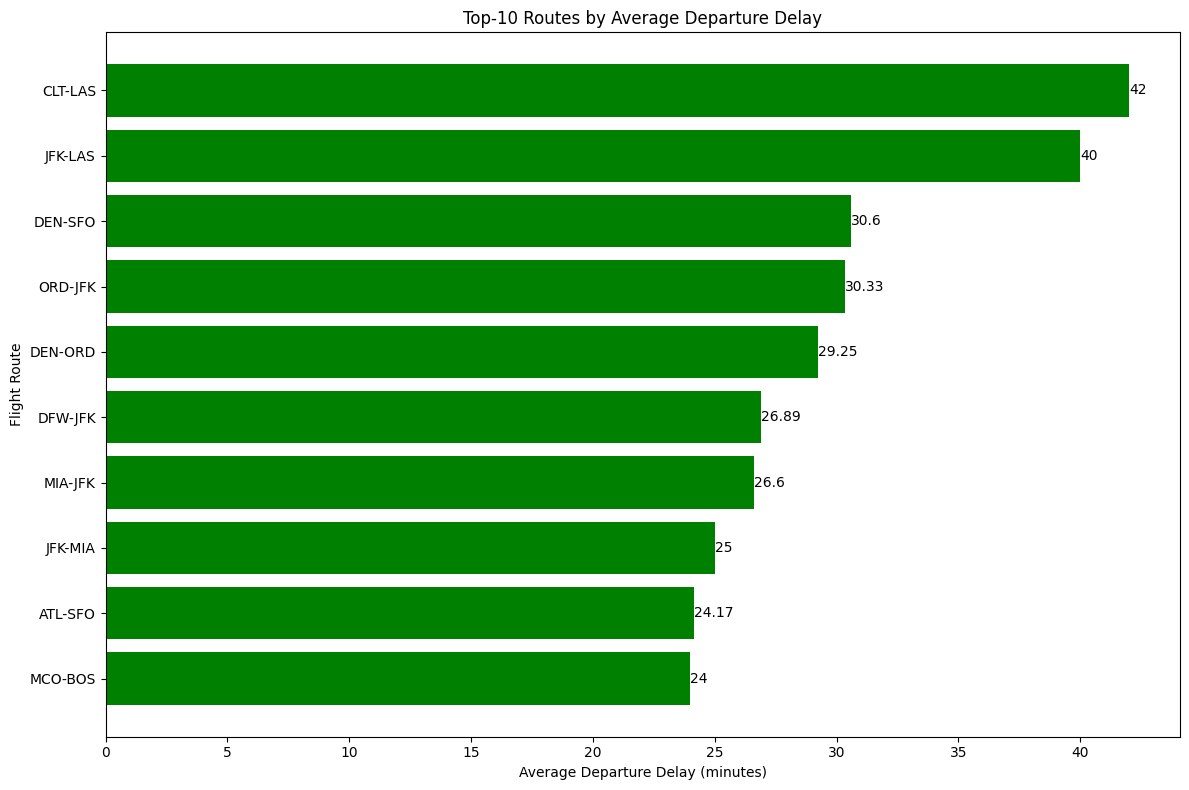

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
#Formatting the Spark DataFrame into a Pandas DataFrame in order to plot the result.
top_delay_PD = final_top_delay.toPandas()

routes = top_delay_PD['ORIGIN_AIRPORT'] + "-" + top_delay_PD['DEST_AIRPORT']

#Convert AVG_DEP_DELAY to float for plotting and labels.
avg_delays_float = top_delay_PD['AVG_DEP_DELAY'].astype(float)

plt.figure(figsize=(12, 8))
bars = plt.barh(routes, avg_delays_float, color="green")

plt.xlabel('Average Departure Delay (minutes)')
plt.ylabel('Flight Route')
plt.title('Top-10 Routes by Average Departure Delay')

plt.bar_label(bars)

plt.xlim(left=0)

plt.gca().invert_yaxis()

plt.tight_layout()

#Saving the plot to a file
plot_filename = "top-10-routes-delay.png"
plt.savefig(plot_filename)

#Showing the plot and closing it.
plt.show()
plt.close()

#Downloading the result.
files.download(plot_filename)

In [12]:
#Stopping Spark session.
spark.stop()

In [13]:
#Calculating Total Runtime and First Action Time.
total_runtime = total_runtime_stop - total_runtime_start
first_action = first_action_stop - first_action_start

print(f"Total Runtime: {round(total_runtime, 3)}")
print(f"First Action Runtime: {round(first_action, 3)}")

Total Runtime: 3.923
First Action Runtime: 3.407
